# Classical MNIST Example

In [1]:
import torch
import torchvision

/home/minzhaoliu/.conda/envs/qtensor_ai/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/minzhaoliu/.conda/envs/qtensor_ai/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [36]:
n_epochs = 1
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [37]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=False)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=False)

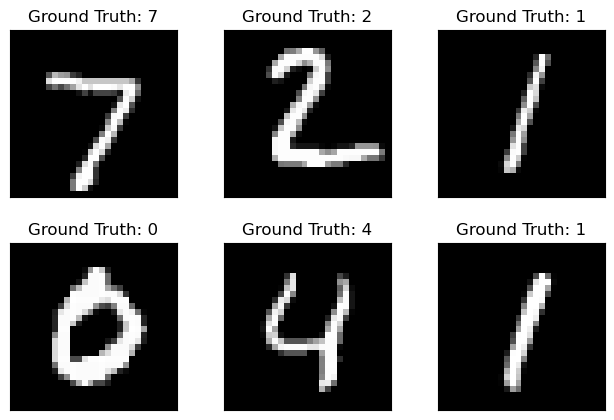

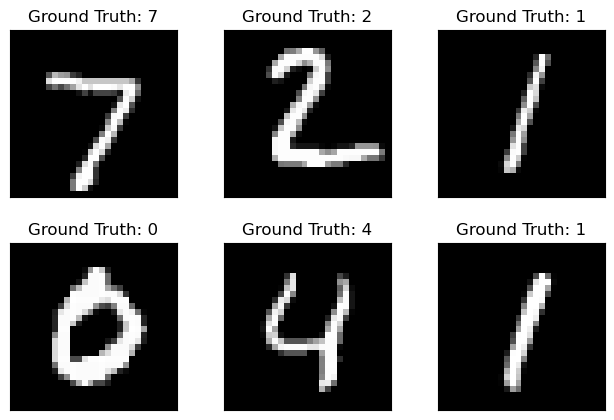

In [38]:
import matplotlib.pyplot as plt

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [39]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(3, 3, kernel_size=(4, 4))
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(75, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 75)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [40]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [41]:
train_losses = []
train_counter = []

In [42]:
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [43]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [44]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [45]:
import os

if not os.path.isdir('./results'):
    os.mkdir('./results')

In [46]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/tmp/ipykernel_245658/2667540704.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/home/minzhaoliu/.conda/envs/qtensor_ai/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3065, Accuracy: 1014/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295618
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.302401
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.307927
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.288408
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.297344
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.293302
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.282939
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.264049
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.279421
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.253555
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.230584
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.235676
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.235559
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.208609
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.142078
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.194622
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.182608
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.080522
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.972861
Train Epoch: 1 [12160

Text(0, 0.5, 'negative log likelihood loss')

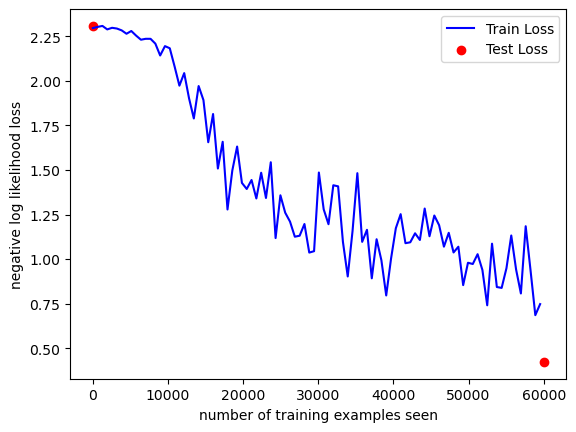

In [47]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [48]:
with torch.no_grad():
  output = network(example_data)

/tmp/ipykernel_245658/2667540704.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


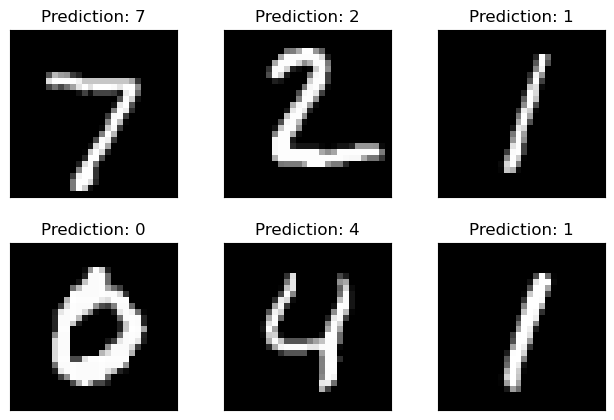

In [49]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])